## Table of Contents

- [Introduction](#intro)
- [Libraries](#lib)
- [Functions & Constants](#func)
- [Data Loading](#load)
- [Data Wrangling](#wrang)
- [Most Popular Items](#pop)
- [Apriori Algorithm](#apri)
- [Product Recommendation](#rec)

## Introduction
<a id="intro" > </a>

**Association Rules Mining**<br>
Association Rules find applications in recommender systems (where customers who purchased item A are recommended item B), product bundling, product placement etc. to name among a few.

Here are 3 key metrics to consider when evaluating association rules:

**support**<br>
This is the percentage of orders that contains the item set. For example, there are 5 orders in total and {apple,egg} occurs in 3 of them, so:

             support{apple,egg} = 3/5 or 60%

The minimum support threshold required by apriori can be set based on knowledge of your domain. <br>
>            support{B} = (Transactions containing {B})/(Total Transactions)

**confidence**<br>
Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that item A was purchased. This is expressed as:

             confidence{A->B} = support{A,B} / support{A}   

Confidence values range from 0 to 1, where 0 indicates that B is never purchased when A is purchased, and 1 indicates that B is always purchased whenever A is purchased. Note that the confidence measure is directional. This means that we can also compute the percentage of times that item A is purchased, given that item B was purchased:

             confidence{B->A} = support{A,B} / support{B}    

For example, the percentage of times that egg is purchased, given that apple was purchased is:

             confidence{apple->egg} = support{apple,egg} / support{apple}
                                    = (3/5) / (4/5)
                                    = 0.75 or 75%

A confidence value of 0.75 implies that out of all orders that contain apple, 75% of them also contain egg. Now, we look at the confidence measure in the opposite direction (ie: egg->apple):

             confidence{egg->apple} = support{apple,egg} / support{egg}
                                    = (3/5) / (3/5)
                                    = 1 or 100%  

Here we see that all of the orders that contain egg also contain apple. But, does this mean that there is a relationship between these two items, or are they occurring together in the same orders simply by chance? To answer this question, we look at another measure which takes into account the popularity of both items.



**lift**<br>
Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance (ie: at random). Unlike the confidence metric whose value may vary depending on direction (eg: confidence{A->B} may be different from confidence{B->A}), lift has no direction. This means that the lift{A,B} is always equal to the lift{B,A}:

             lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})   

In our example, we compute lift as follows:

  lift{apple,egg} = lift{egg,apple} = support{apple,egg} / (support{apple} * support{egg})
                  = (3/5) / (4/5 * 3/5) 
                  = 1.25    

One way to understand lift is to think of the denominator as the likelihood that A and B will appear in the same order if there was no relationship between them. In the example above, if apple occurred in 80% of the orders and egg occurred in 60% of the orders, then if there was no relationship between them, we would expect both of them to show up together in the same order 48% of the time (ie: 80% * 60%). The numerator, on the other hand, represents how often apple and egg actually appear together in the same order. In this example, that is 60% of the time. Taking the numerator and dividing it by the denominator, we get to how many more times apple and egg actually appear in the same order, compared to if there was no relationship between them (ie: that they are occurring together simply at random).

In summary, lift can take on the following values:

 * lift = 1 implies no relationship between A and B. 
   (ie: A and B occur together only by chance)

 * lift > 1 implies that there is a positive relationship between A and B.
   (ie:  A and B occur together more often than random)

 * lift < 1 implies that there is a negative relationship between A and B.
   (ie:  A and B occur together less often than random)

In our example, apple and egg occur together 1.25 times more than random, so we conclude that there exists a positive relationship between them.


## Import Libraries
<a id="lib" > </a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/groceries-dataset/Groceries_dataset.csv


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from mlxtend.frequent_patterns import association_rules, apriori, fpgrowth

## Functions and Constants
<a id="func" > </a>

**Constants**

In [3]:
SINGLE_ITEM_ONLY = False
MIN_ITEMS_HEATMAP=1

if SINGLE_ITEM_ONLY:
    MIN_ITEMS_HEATMAP=1

**Functions**

In [4]:
#Used in Data Wrangling to make dataframe compatible with apriori()
def to_boolean(x):
    if x == 0:
        return False
    elif x > 0:
        return True
    
    
# To create metrics Support, Confidence, Lift for Antecedents and Consequent items
def apriori_df(dataframe_support, metric_name, threshold):
    apriori_rules = association_rules(dataframe_support, metric = metric_name, min_threshold = threshold)

    apriori_rules['antecedents_items'] = apriori_rules['antecedents'].apply(lambda x:len(x) )
    apriori_rules['consequents_items'] = apriori_rules['consequents'].apply(lambda x:len(x) )

    apriori_rules['antecedents_'] = apriori_rules['antecedents'].apply(lambda a: ','.join(list(a)))
    apriori_rules['consequents_'] = apriori_rules['consequents'].apply(lambda a: ','.join(list(a)))

    apriori_rules.sort_values('confidence', ascending = False, inplace = True)

    if SINGLE_ITEM_ONLY:
        apriori_rules= apriori_rules[(apriori_rules['antecedents_items'] ==1) & (apriori_rules['consequents_items'] ==1)]
    return apriori_rules


# To make a recommendation based on association rules
def recommend_product(dataframe_apriori, product, num_of_products):
    dataframe_apriori.sort_values('confidence', ascending = False, inplace = True)
    recommendation_list = []  
    for index, row in dataframe_apriori.iterrows():
        if product in row["antecedents_"]:
            recommendation_list.append(row["consequents_"])
    return(recommendation_list[0:num_of_products])


## Load Data
<a id="load" > </a>

In [5]:
df= pd.read_csv("../input/groceries-dataset/Groceries_dataset.csv")
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


## Data Description

In [6]:
df.dtypes
df["Date"]=  pd.to_datetime(df['Date'])

#Let us prune the dataset
df= df[df["Date"] >= "2015-01-01"]

#### Check for NULL Values

In [7]:
df.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [8]:
#Total number of observation points
len(df)

20488

In [9]:
# How many unique Items and Customers are there in the dataset
print(df["itemDescription"].nunique())
print(df["Member_number"].nunique())

164
3314


We can remove some of the unnecessary items from our analysis that do not contribute any value, like ShoppingBags. But right now, let us take all the items in the dataset.

## Data Wrangling: Convert to apriori() compatible format
<a id="wrang" > </a>

We will use simple unstacking to convert our data into apriori algorithm compatible form. The algorithm expects the data in Boolean form. Binary form is now deprecated.<br>
If our data is in the form of lists (e.g., basket1: [apple, banana], basket2: [tea, mango, candy]), then we can also use TransactionEncoder to transform the data into this format.<br>
Assumption Alert: We are assuming that each Member on a given Date has 1 Basket only

In [10]:
basket = df.groupby(["Member_number",'Date', 'itemDescription'])['itemDescription'].count().unstack().fillna(0)
basket.head()

itemDescription           Instant food products  UHT-milk  abrasive cleaner  \
Member_number Date                                                            
1000          2015-03-15                    0.0       0.0               0.0   
              2015-05-27                    0.0       0.0               0.0   
              2015-07-24                    0.0       0.0               0.0   
              2015-11-25                    0.0       0.0               0.0   
1001          2015-01-20                    0.0       0.0               0.0   

itemDescription           artif. sweetener  baby cosmetics  bags  \
Member_number Date                                                 
1000          2015-03-15               0.0             0.0   0.0   
              2015-05-27               0.0             0.0   0.0   
              2015-07-24               0.0             0.0   0.0   
              2015-11-25               0.0             0.0   0.0   
1001          2015-01-20               0.0             0.0   0.0   

itemDescription           baking powder  bathroom cleaner  beef  berries  ...  \
Member_number Date                                                        ...   
1000          2015-03-15            0.0               0.0   0.0      0.0  ...   
              2015-05-27            0.0               0.0   0.0      0.0  ...   
              2015-07-24            0.0               0.0   0.0      0.0  ...   
              2015-11-25            0.0               0.0   0.0      0.0  ...   
1001          2015-01-20            0.0               0.0   0.0      0.0  ...   

itemDescription           turkey  vinegar  waffles  whipped/sour cream  \
Member_number Date                                                       
1000          2015-03-15     0.0      0.0      0.0                 0.0   
              2015-05-27     0.0      0.0      0.0                 0.0   
              2015-07-24     0.0      0.0      0.0                 0.0   
              2015-11-25     0.0      0.0      0.0                 0.0   
1001          2015-01-20     0.0      0.0      0.0                 1.0   

itemDescription           whisky  white bread  white wine  whole milk  yogurt  \
Member_number Date                                                              
1000          2015-03-15     0.0          0.0         0.0         1.0     1.0   
              2015-05-27     0.0          0.0         0.0         0.0     0.0   
              2015-07-24     0.0          0.0         0.0         0.0     0.0   
              2015-11-25     0.0          0.0         0.0         0.0     0.0   
1001          2015-01-20     0.0          0.0         0.0         0.0     0.0   

itemDescription           zwieback  
Member_number Date                  
1000          2015-03-15       0.0  
              2015-05-27       0.0  
              2015-07-24       0.0  
              2015-11-25       0.0  
1001          2015-01-20       0.0  

[5 rows x 164 columns]

In [11]:
basket_bool = basket.applymap(to_boolean)
basket_bool.head()

itemDescription           Instant food products  UHT-milk  abrasive cleaner  \
Member_number Date                                                            
1000          2015-03-15                  False     False             False   
              2015-05-27                  False     False             False   
              2015-07-24                  False     False             False   
              2015-11-25                  False     False             False   
1001          2015-01-20                  False     False             False   

itemDescription           artif. sweetener  baby cosmetics   bags  \
Member_number Date                                                  
1000          2015-03-15             False           False  False   
              2015-05-27             False           False  False   
              2015-07-24             False           False  False   
              2015-11-25             False           False  False   
1001          2015-01-20             False           False  False   

itemDescription           baking powder  bathroom cleaner   beef  berries  \
Member_number Date                                                          
1000          2015-03-15          False             False  False    False   
              2015-05-27          False             False  False    False   
              2015-07-24          False             False  False    False   
              2015-11-25          False             False  False    False   
1001          2015-01-20          False             False  False    False   

itemDescription           ...  turkey  vinegar  waffles  whipped/sour cream  \
Member_number Date        ...                                                 
1000          2015-03-15  ...   False    False    False               False   
              2015-05-27  ...   False    False    False               False   
              2015-07-24  ...   False    False    False               False   
              2015-11-25  ...   False    False    False               False   
1001          2015-01-20  ...   False    False    False                True   

itemDescription           whisky  white bread  white wine  whole milk  yogurt  \
Member_number Date                                                              
1000          2015-03-15   False        False       False        True    True   
              2015-05-27   False        False       False       False   False   
              2015-07-24   False        False       False       False   False   
              2015-11-25   False        False       False       False   False   
1001          2015-01-20   False        False       False       False   False   

itemDescription           zwieback  
Member_number Date                  
1000          2015-03-15     False  
              2015-05-27     False  
              2015-07-24     False  
              2015-11-25     False  
1001          2015-01-20     False  

[5 rows x 164 columns]

In [12]:
len(basket_bool)

6982

## Most Popular Items
<a id="pop" > </a>

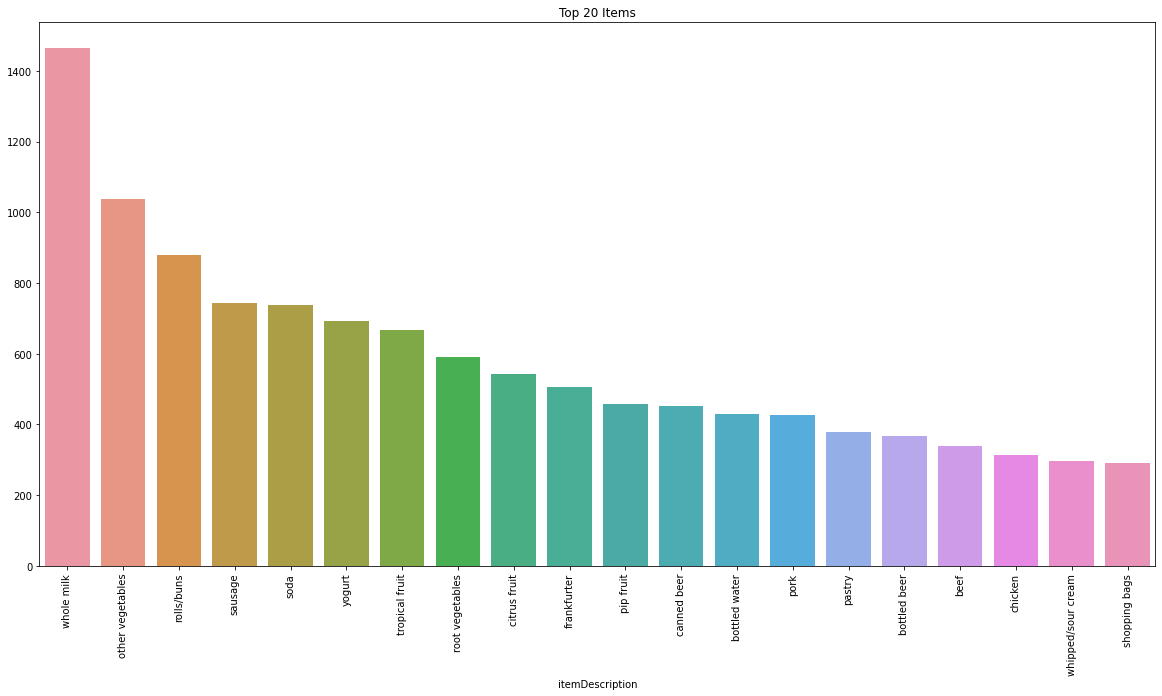

In [13]:
##Lets consider the top 20 items purchased most frequently
popular_items = basket.sum(axis=0).sort_values(ascending=False)[:20]
#altering the figsize
plt.figure(figsize=(20,10))
sns.barplot(x=popular_items.index,y=popular_items.values)
plt.xticks(rotation='vertical')
plt.title("Top 20 Items")
plt.show()

(0.0, 100.0, 0.0, 100.0)

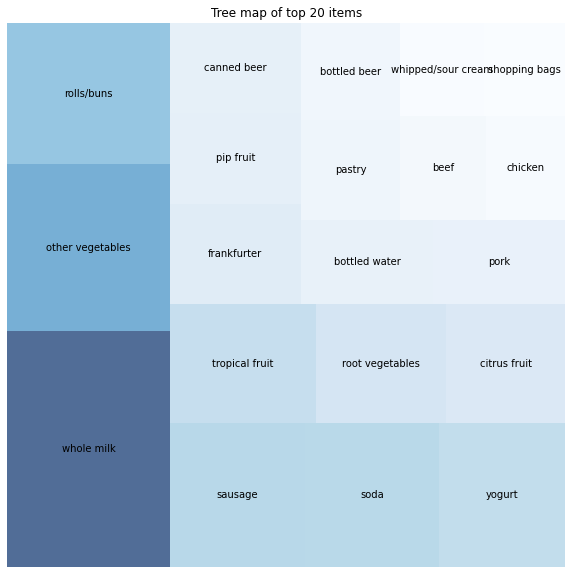

In [14]:
# create a color palette, mapped to these values
popular_items_freq =popular_items.values
cmap = matplotlib.cm.Blues
mini=min(popular_items_freq)
maxi=max(popular_items_freq)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in popular_items_freq]


#treemap of top 20 frequent items
plt.figure(figsize=(10,10))
squarify.plot(sizes=popular_items.values, label=popular_items.index, alpha=.7,color=colors)
plt.title("Tree map of top 20 items")
plt.axis('off')

## Apriori Algorithm
<a id="apri" > </a>

If SINGLE_ITEM_ONLY==True, then we will limit length to <=2 because we would like to see one-on-one association only, like {beer,milk}. If we have length >2 , then we may also see associations like: {(beer,apple),milk}. 

In [15]:
frequent_items = apriori(basket_bool, min_support = 0.01, use_colnames = True)
frequent_items.head()

,support,itemsets
0,0.023059,(UHT-milk)
1,0.047551,(beef)
2,0.028359,(berries)
3,0.019908,(beverages)
4,0.052134,(bottled beer)


Creating Metrics of Support, Confidence, List for Antecedents and Consequent items

In [16]:
apriori_rules= apriori_df(dataframe_support= frequent_items, metric_name= "lift", threshold =1.01)
apriori_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_items,consequents_items,antecedents_,consequents_
0,(soda),(sausage),0.100401,0.103552,0.011601,0.115549,1.115857,0.001205,1.013565,1,1,soda,sausage
2,(yogurt),(sausage),0.095102,0.103552,0.010885,0.114458,1.105318,0.001037,1.012315,1,1,yogurt,sausage
1,(sausage),(soda),0.103552,0.100401,0.011601,0.112033,1.115857,0.001205,1.013100,1,1,sausage,soda
3,(sausage),(yogurt),0.103552,0.095102,0.010885,0.105118,1.105318,0.001037,1.011192,1,1,sausage,yogurt


## Visualising Association Rules

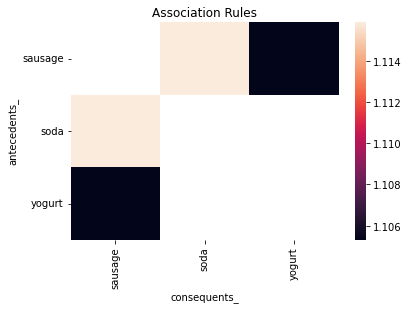

In [17]:
#apriori_rules[apriori_rules['antecedents_items']>= MIN_ITEMS_HEATMAP].sort_values('lift', ascending=False).head()
pivot = apriori_rules[apriori_rules['antecedents_items']>= MIN_ITEMS_HEATMAP].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
#sns.heatmap(pivot, annot = True)
sns.heatmap(pivot)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Association Rules")
plt.show()

## Product Recommendation
<a id="rec" > </a>

In [18]:
recommend_product(dataframe_apriori= apriori_rules, product="yogurt", num_of_products=1)

['sausage']

**Future Ideas**<br>
- ECLAT Algorithm
- FP Tree Algorithm
- PyARMViz module for Association Visualization

**References:** <br>
- https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis
- https://www.kaggle.com/code/annettecatherinepaul/apriori-algorithm-association-rule-mining
- https://www.kaggle.com/code/sajidcse/market-basket-analysis
- https://www.kaggle.com/code/ozlemilgun/market-basket-analysis-with-apriori-algorithm

